<a href="https://practicalai.me"><img src="https://raw.githubusercontent.com/practicalAI/images/master/images/rounded_logo.png" width="100" align="left" hspace="20px" vspace="20px"></a>

<img src="https://raw.githubusercontent.com/practicalAI/images/master/basic_ml/12_Recurrent_Neural_Networks/simple_rnn.png" width="250" align="right">

<div align="left">
<h1>Recurrent Neural Networks (RNN) </h1>

In this lesson we will learn how to process sequential data (sentences, time-series, etc.) with recurrent neural networks (RNNs). 

<table align="center">
  <td>
<img src="https://raw.githubusercontent.com/practicalAI/images/master/images/rounded_logo.png" width="25"><a target="_blank" href="https://practicalai.me"> View on practicalAI</a>
  </td>
  <td>
<img src="https://raw.githubusercontent.com/practicalAI/images/master/images/colab_logo.png" width="25"><a target="_blank" href="https://colab.research.google.com/github/practicalAI/practicalAI/blob/master/notebooks/12_Recurrent_Neural_Networks.ipynb"> Run in Google Colab</a>
  </td>
  <td>
<img src="https://raw.githubusercontent.com/practicalAI/images/master/images/github_logo.png" width="22"><a target="_blank" href="https://github.com/practicalAI/practicalAI/blob/master/notebooks/basic_ml/12_Recurrent_Neural_Networks.ipynb"> View code on GitHub</a>
  </td>
</table>

So far we've processed inputs as whole (ex. applying filters across the entire input to extract features) but we can also processed our inputs sequentially. To illustrate what this looks like, suppose our inputs are sentences (like the news dataset inputs we've seen in previous lessons). Think of each word/puncutation (or token) in the sentence as a timestep. So a sentence with 8 tokens has 8 timesteps. We can process each timestep, one at a time, and predict the class after the last timestep (token) has been processed. This is very powerful because the model now has a meaningful way to account for the order in our sequence and predict accordingly. 

# Overview

* **Objective:**  Process sequential data by accounting for the currend input and also what has been learned from previous inputs.
* **Advantages:** 
    * Account for order and previous inputs in a meaningful way.
    * Conditioned generation for generating sequences.
* **Disadvantages:** 
    * Each time step's prediction depends on the previous prediction so it's difficult to parallelize RNN operations. 
    * Processing long sequences can yield memory and computation issues.
    * Interpretability is difficult but there are few [techniques](https://arxiv.org/abs/1506.02078) that use the activations from RNNs to see what parts of the inputs are processed. 
* **Miscellaneous:** 
    * Architectural tweaks to make RNNs faster and interpretable is an ongoing area of research.

# Set up

In [0]:
# Use TensorFlow 2.x
%tensorflow_version 2.x

TensorFlow 2.x selected.


In [0]:
import os
import numpy as np
import tensorflow as tf
print("GPU Available: ", tf.test.is_gpu_available())

GPU Available:  True


In [0]:
# Arguments
SEED = 1234
SHUFFLE = True
DATA_FILE = 'news.csv'
INPUT_FEATURE = 'title'
OUTPUT_FEATURE = 'category'
FILTERS = "!\"'#$%&()*+,-./:;<=>?@[\\]^_`{|}~"
LOWER = True
CHAR_LEVEL = False
TRAIN_SIZE = 0.7
VAL_SIZE = 0.15
TEST_SIZE = 0.15
NUM_EPOCHS = 10
BATCH_SIZE = 256
EMBEDDING_DIM = 100
RNN_HIDDEN_DIM = 128
RNN_DROPOUT_P = 0.1
NUM_LAYERS = 1
HIDDEN_DIM = 100
DROPOUT_P = 0.1
LEARNING_RATE = 1e-3
EARLY_STOPPING_CRITERIA = 3

In [0]:
# Set seed for reproducability
np.random.seed(SEED)
tf.random.set_seed(SEED)

# Data

We will download the [AG News dataset](http://www.di.unipi.it/~gulli/AG_corpus_of_news_articles.html), which consists of 120000 text samples from 4 unique classes ('Business', 'Sci/Tech', 'Sports', 'World')

In [0]:
import pandas as pd
import re
import urllib

In [0]:
# Upload data from GitHub to notebook's local drive
url = "https://raw.githubusercontent.com/practicalAI/practicalAI/master/data/news.csv"
response = urllib.request.urlopen(url)
html = response.read()
with open(DATA_FILE, 'wb') as fp:
    fp.write(html)

In [0]:
# Load data
df = pd.read_csv(DATA_FILE, header=0)
X = df[INPUT_FEATURE].values
y = df[OUTPUT_FEATURE].values
df.head(5)

,title,category
0,Wall St. Bears Claw Back Into the Black (Reuters),Business
1,Carlyle Looks Toward Commercial Aerospace (Reu...,Business
2,Oil and Economy Cloud Stocks' Outlook (Reuters),Business
3,Iraq Halts Oil Exports from Main Southern Pipe...,Business
4,"Oil prices soar to all-time record, posing new...",Business


# Split data

In [0]:
import collections
from sklearn.model_selection import train_test_split

### Components

In [0]:
def train_val_test_split(X, y, val_size, test_size, shuffle):
    """Split data into train/val/test datasets.
    """
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, stratify=y, shuffle=shuffle)
    X_train, X_val, y_train, y_val = train_test_split(
        X_train, y_train, test_size=val_size, stratify=y_train, shuffle=shuffle)
    return X_train, X_val, X_test, y_train, y_val, y_test

### Operations

In [0]:
# Create data splits
X_train, X_val, X_test, y_train, y_val, y_test = train_val_test_split(
    X=X, y=y, val_size=VAL_SIZE, test_size=TEST_SIZE, shuffle=SHUFFLE)
class_counts = dict(collections.Counter(y))
print (f"X_train: {X_train.shape}, y_train: {y_train.shape}")
print (f"X_val: {X_val.shape}, y_val: {y_val.shape}")
print (f"X_test: {X_test.shape}, y_test: {y_test.shape}")
print (f"X_train[0]: {X_train[0]}")
print (f"y_train[0]: {y_train[0]}")
print (f"Classes: {class_counts}")

X_train: (86700,), y_train: (86700,)
X_val: (15300,), y_val: (15300,)
X_test: (18000,), y_test: (18000,)
X_train[0]: With protesters waiting, Powell cancels trip to Olympics
y_train[0]: Sports
Classes: {'Business': 30000, 'Sci/Tech': 30000, 'Sports': 30000, 'World': 30000}


# Tokenizer

Unlike the previous notebook, we will be processing our text at a word-level (as opposed to character-level).

In [0]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical

### Components

In [0]:
def untokenize(indices, tokenizer):
    """Untokenize a list of indices into string."""
    return " ".join([tokenizer.index_word[index] for index in indices])

### Operations

In [0]:
# Input vectorizer
X_tokenizer = Tokenizer(filters=FILTERS,
                        lower=LOWER,
                        char_level=CHAR_LEVEL,
                        oov_token='<UNK>')

In [0]:
# Fit only on train data
X_tokenizer.fit_on_texts(X_train)
vocab_size = len(X_tokenizer.word_index) + 1
print (f"# tokens: {vocab_size}")

# tokens: 29872


In [0]:
# Convert text to sequence of tokens
original_text = X_train[0]
X_train = np.array(X_tokenizer.texts_to_sequences(X_train))
X_val = np.array(X_tokenizer.texts_to_sequences(X_val))
X_test = np.array(X_tokenizer.texts_to_sequences(X_test))
preprocessed_text = untokenize(X_train[0], X_tokenizer)
print (f"{original_text} \n\t→ {preprocessed_text} \n\t→ {X_train[0]}")

SCO caps legal costs as losses mount 
	→ sco caps legal costs as losses mount 
	→ [2451, 3953, 762, 568, 21, 1015, 1249]


# LabelEncoder

In [0]:
from sklearn.preprocessing import LabelEncoder

### Operations

In [0]:
# Output vectorizer
y_tokenizer = LabelEncoder()

In [0]:
# Fit on train data
y_tokenizer = y_tokenizer.fit(y_train)
classes = list(y_tokenizer.classes_)
print (f"classes: {classes}")

classes: ['Business', 'Sci/Tech', 'Sports', 'World']


In [0]:
# Convert labels to tokens
y_train = y_tokenizer.transform(y_train)
y_val = y_tokenizer.transform(y_val)
y_test = y_tokenizer.transform(y_test)
print (f"y_train[0]: {y_train[0]}")

y_train[0]: 2


In [0]:
# Class weights
counts = np.bincount(y_train)
class_weights = {i: 1.0/count for i, count in enumerate(counts)}
print (f"class counts: {counts},\nclass weights: {class_weights}")

class counts: [21675 21675 21675 21675],
class weights: {0: 4.61361014994233e-05, 1: 4.61361014994233e-05, 2: 4.61361014994233e-05, 3: 4.61361014994233e-05}


# Generators

In [0]:
import math
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import Sequence

### Components

In [0]:
class DataGenerator(Sequence):
    """Custom data loader."""
    def __init__(self, X, y, batch_size, shuffle=True):
        self.X = X
        self.y = y
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        """# of batches."""
        return math.ceil(len(self.X) / self.batch_size)

    def __str__(self):
        return (f"<DataGenerator(" \
                f"batch_size={self.batch_size}, " \
                f"batches={len(self)}, " \
                f"shuffle={self.shuffle})>")

    def __getitem__(self, index):
        """Generate a batch."""

        # Gather indices for this batch
        batch_indices = self.epoch_indices[index*self.batch_size:(index+1)*self.batch_size]

        # Generate batch data
        inputs, outputs = self.create_batch(batch_indices=batch_indices)

        return inputs, outputs

    def on_epoch_end(self):
        """Create indices after each epoch."""
        self.epoch_indices = np.arange(len(self.X))
        if self.shuffle == True:
            np.random.shuffle(self.epoch_indices)

    def create_batch(self, batch_indices):
        """Generate data from indices."""
        X = self.X[batch_indices]
        y = self.y[batch_indices]
        
        # Sequence lengths
        seq_lengths = np.array([[i, len(x)-1] for i, x in enumerate(X)])

        # Pad batch
        max_seq_len = max([len(x) for x in X])
        X = pad_sequences(X, padding="post", maxlen=max_seq_len)

        return [X, seq_lengths], y

### Operations

In [0]:
# Dataset generator
training_generator = DataGenerator(X=X_train,
                                   y=y_train,
                                   batch_size=BATCH_SIZE,
                                   shuffle=SHUFFLE)
validation_generator = DataGenerator(X=X_val,
                                     y=y_val,
                                     batch_size=BATCH_SIZE,
                                     shuffle=False)
testing_generator = DataGenerator(X=X_test,
                                  y=y_test,
                                  batch_size=BATCH_SIZE,
                                  shuffle=False)

In [0]:
print (f"training_generator: {training_generator}")
print (f"validation_generator: {validation_generator}")
print (f"testing_generator: {testing_generator}")

training_generator: <DataGenerator(batch_size=256, batches=339, shuffle=True)>
validation_generator: <DataGenerator(batch_size=256, batches=60, shuffle=False)>
testing_generator: <DataGenerator(batch_size=256, batches=71, shuffle=False)>


# Input

Inputs to RNNs are sequential like text or time-series.

In [0]:
from tensorflow.keras.layers import Input

In [0]:
# Input
sequence_size = 8 # words per input
x = Input(shape=(sequence_size, EMBEDDING_DIM))
print (x)

Tensor("input_1:0", shape=(None, 8, 100), dtype=float32)


# Simple RNN

<img src="https://raw.githubusercontent.com/practicalAI/images/master/basic_ml/12_Recurrent_Neural_Networks/simple_rnn.png" width="500">

RNN forward pass for a single time step $X_t$:

$h_t = tanh(W_{hh}h_{t-1} + W_{xh}X_t+b_h)$

*where*:
* $W_{hh}$ = hidden units weights| $\in \mathbb{R}^{HXH}$ ($H$ is the hidden dim)
* $h_{t-1}$ = previous timestep's hidden state $\in \mathbb{R}^{NXH}$
* $W_{xh}$ = input weights| $\in \mathbb{R}^{EXH}$
* $X_t$ = input at time step t | $\in \mathbb{R}^{NXE}$ ($N$ is the batch size, $E$ is the embedding dim)
* $b_h$ = hidden units bias $\in \mathbb{R}^{HX1}$
* $h_t$ = output from RNN for timestep $t$

<div align="left">
<img src="https://raw.githubusercontent.com/practicalAI/images/master/images/lightbulb.gif" width="45px" align="left" hspace="10px" vspace="10px">
</div>

At the first time step, the previous hidden state $h_{t-1}$ can either be a zero vector (unconditioned) or initialized (conditioned). If we are conditioning the RNN, the first hidden state $h_0$ can belong to a specific condition or we can concat the specific condition to the randomly initialized hidden vectors at each time step. More on this in the subsequent notebooks on RNNs.

In [0]:
from tensorflow.keras.layers import SimpleRNN

In [0]:
# RNN forward pass (many to one)
rnn = SimpleRNN(units=RNN_HIDDEN_DIM, 
                dropout=DROPOUT_P, 
                recurrent_dropout=RNN_DROPOUT_P,
                return_sequences=False, # only get the output from the last sequential input
                return_state=True)
output, hidden_state = rnn(x)
print (f"output {output.shape}")
print (f"hidden {hidden_state.shape}")

output (None, 128)
hidden (None, 128)


In [0]:
# RNN forward pass (many to many)
rnn = SimpleRNN(units=RNN_HIDDEN_DIM, 
                dropout=DROPOUT_P, 
                recurrent_dropout=RNN_DROPOUT_P,
                return_sequences=True, # get outputs from every item in sequential input
                return_state=True)
outputs, hidden_state = rnn(x)
print (f"output {outputs.shape}")
print (f"hidden {hidden_state.shape}")

output (None, 8, 128)
hidden (None, 128)


There are many different ways to use RNNs. So far we've processed our inputs one timestep at a time and we could either use the RNN's output at each time step or just use the final input timestep's RNN output. Let's look at a few other possibilities.

<img src="https://raw.githubusercontent.com/practicalAI/images/master/basic_ml/12_Recurrent_Neural_Networks/rnn_examples.png" width="1000">

# Model

**Simple RNN**

In [0]:
import tensorflow.keras.backend as K
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Masking
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

### Components

In [0]:
class TextClassificationRNNModel(Model):
    def __init__(self, vocab_size, embedding_dim, rnn_cell, 
                 hidden_dim, dropout_p, num_classes):
        super(TextClassificationRNNModel, self).__init__()

        # Embeddings
        self.embedding = Embedding(input_dim=vocab_size,
                                   output_dim=embedding_dim,
                                   mask_zero=True,
                                   trainable=True)
        
        # Masking
        self.mask = Masking(mask_value=0.)
        
        # RNN
        self.rnn = rnn_cell
        
        # FC layers
        self.fc1 = Dense(units=hidden_dim, activation='relu')
        self.dropout = Dropout(rate=dropout_p)
        self.fc2 = Dense(units=num_classes, activation='softmax')

    def call(self, inputs, training=False):
        """Forward pass."""
        
        # Inputs
        x_in, seq_lengths = inputs

        # Embed
        x_emb = self.embedding(x_in)
        
        # Masking
        z = self.mask(x_emb)

        # RNN
        z, hidden_state = self.rnn(x_emb)

        # Gather last relevant index
        z = tf.gather_nd(z, K.cast(seq_lengths, 'int32'))

        # FC
        z = self.fc1(z)
        if training:
            z = self.dropout(z, training=training)
        y_pred = self.fc2(z)

        return y_pred
    
    def sample(self, x_in_shape, seq_lengths_shape):
        x_in = Input(shape=x_in_shape)
        seq_lengths = Input(shape=seq_lengths_shape)
        inputs = [x_in, seq_lengths]
        return Model(inputs=inputs, outputs=self.call(inputs)).summary()

In our model, we want to use the RNN's output after the last relevant token in the sentence is processed. The last relevant token doesn't refer the <PAD> tokens but to the last actual word in the sentence and its index is different for each input in the batch.

This is why we included a `seq_lengths` variable in our `create_batch` function in the `Generator` class. The seq_lengths are passed in to the forward pass as an input and we use [tf.gather_nd](https://www.tensorflow.org/api_docs/python/tf/gather_nd) to gather the last relevant hidden state (before padding starts). 

```
def create_batch(self, batch_indices):
    ...
    # Sequence lengths
    seq_lengths = np.array([[i, len(x)-1] for i, x in enumerate(X)])
    ...
    return [X, seq_lengths], y
```

Once we have the relevant hidden state extracted, we proceed to apply some fully-connected layers (with softmax) to generate the class probabilities.

# Inspection

Let's say you want more transparency on the exact shapes of the inputs and outputs at every stage of your model. Well you could architect a model that just works and you can use model.sample() to see the summary but what if you have issues in the model in the first place? 

In [0]:
# Get the first data point
sample_inputs, sample_y = training_generator.create_batch([0]) 

In [0]:
sample_X, sample_seq_length = sample_inputs
print (f"sample_X: {sample_X} ==> shape: {sample_X.shape}")
print (f"sample_seq_length: {sample_seq_length} ==> shape: {sample_seq_length.shape}")
print (f"sample_y: {sample_y} ==> shape: {sample_y.shape}")

sample_X: [[  18 2087 2186  709 1653 1202    2  672]] ==> shape: (1, 8)
sample_seq_length: [[0 7]] ==> shape: (1, 2)
sample_y: [2] ==> shape: (1,)


Now we will create a smaller model to the point that we want to inspect. This is a great way to iteratively build your model, validating the output shapes at every step of the way.

In [0]:
class ModelToInspect(Model):
    def __init__(self, vocab_size, embedding_dim, rnn_cell, 
                 hidden_dim, dropout_p, num_classes):
        super(ModelToInspect, self).__init__()

        # Embeddings
        self.embedding = Embedding(input_dim=vocab_size,
                                   output_dim=embedding_dim,
                                   mask_zero=True,
                                   trainable=True)
        
        # Masking
        self.mask = Masking(mask_value=0.)
        
        # RNN
        self.rnn = rnn_cell

    def call(self, inputs, training=False):
        """Forward pass."""
        
        # Forward pass
        x_in, seq_lengths = inputs
        x_emb = self.embedding(x_in)
        z = self.mask(x_emb)
        z, hidden_state = self.rnn(x_emb)
        
        return z
    
    def sample(self, x_in_shape, seq_lengths_shape):
        x_in = Input(shape=x_in_shape)
        seq_lengths = Input(shape=seq_lengths_shape)
        inputs = [x_in, seq_lengths]
        return Model(inputs=inputs, outputs=self.call(inputs)).summary()

In [0]:
# RNN cell
simple_rnn = SimpleRNN(units=RNN_HIDDEN_DIM, 
                       dropout=DROPOUT_P, 
                       recurrent_dropout=RNN_DROPOUT_P,
                       return_sequences=True,
                       return_state=True) 

In [0]:
model = ModelToInspect(vocab_size=vocab_size,
                       embedding_dim=EMBEDDING_DIM,
                       rnn_cell=simple_rnn,
                       hidden_dim=HIDDEN_DIM,
                       dropout_p=DROPOUT_P,
                       num_classes=len(classes))
model.sample(x_in_shape=(sample_X.shape[1],), seq_lengths_shape=(2,))

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 8)]          0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 8, 100)       2987200     input_2[0][0]                    
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 2)]          0                                            
__________________________________________________________________________________________________
simple_rnn_3 (SimpleRNN)        [(None, 8, 128), (No 29312       embedding[0][0]                  
Total params: 3,016,512
Trainable params: 3,016,512
Non-trainable params: 0
__________________

In [0]:
z = model(sample_inputs)
print (f"z: {z} ==> shape: {z.shape}")

z: [[[ 0.00820867 -0.02330007 -0.02288972 ... -0.03135864  0.00753112
   -0.01934274]
  [ 0.04829089  0.01333961  0.04919123 ... -0.11085248 -0.01596617
    0.02034008]
  [ 0.06126435 -0.02994554  0.00135956 ... -0.03555164  0.10374444
   -0.03651815]
  ...
  [-0.0012784   0.10571703  0.04443682 ...  0.0003274  -0.00568285
   -0.04744783]
  [-0.04378117 -0.13406402  0.13039635 ...  0.14210068  0.08378843
   -0.10440754]
  [-0.01132762 -0.08137172 -0.1193947  ...  0.10263453 -0.01641675
    0.02320403]]] ==> shape: (1, 8, 128)


The mode.sample() provided a decent summary of the shapes but with our close inspection strategy, we are able to see actual values for a specific input.

# Training

In [0]:
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import TensorBoard
%load_ext tensorboard

In [0]:
# RNN cell
simple_rnn = SimpleRNN(units=RNN_HIDDEN_DIM, 
                       dropout=DROPOUT_P, 
                       recurrent_dropout=RNN_DROPOUT_P,
                       return_sequences=True,
                       return_state=True) 

In [0]:
model = TextClassificationRNNModel(vocab_size=vocab_size,
                                   embedding_dim=EMBEDDING_DIM,
                                   rnn_cell=simple_rnn,
                                   hidden_dim=HIDDEN_DIM,
                                   dropout_p=DROPOUT_P,
                                   num_classes=len(classes))
model.sample(x_in_shape=(sequence_size,), seq_lengths_shape=(2,))

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 8)]          0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 8, 100)       2987200     input_4[0][0]                    
__________________________________________________________________________________________________
input_5 (InputLayer)            [(None, 2)]          0                                            
__________________________________________________________________________________________________
simple_rnn_4 (SimpleRNN)        [(None, 8, 128), (No 29312       embedding_1[0][0]                
____________________________________________________________________________________________

In [0]:
# Compile
model.compile(optimizer=Adam(lr=LEARNING_RATE),
              loss=SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [0]:
# Callbacks
callbacks = [EarlyStopping(monitor='val_loss', patience=EARLY_STOPPING_CRITERIA, verbose=1, mode='min'),
             ReduceLROnPlateau(patience=1, factor=0.1, verbose=0),
             TensorBoard(log_dir='tensorboard/simple_rnn', histogram_freq=1, update_freq='epoch')]

In [0]:
# Training
training_history = model.fit_generator(generator=training_generator,
                                       epochs=NUM_EPOCHS,
                                       validation_data=validation_generator,
                                       callbacks=callbacks,
                                       shuffle=False,
                                       class_weight=class_weights,
                                       verbose=1)

Epoch 1/10
339/339 [==============================] - 46s 136ms/step - loss: 5.8538e-05 - accuracy: 0.2998 - val_loss: 0.8294 - val_accuracy: 0.6992
Epoch 2/10
339/339 [==============================] - 45s 132ms/step - loss: 2.9162e-05 - accuracy: 0.7392 - val_loss: 0.4876 - val_accuracy: 0.8310
Epoch 3/10
339/339 [==============================] - 45s 132ms/step - loss: 1.9858e-05 - accuracy: 0.8528 - val_loss: 0.4259 - val_accuracy: 0.8525
Epoch 4/10
339/339 [==============================] - 44s 130ms/step - loss: 1.6225e-05 - accuracy: 0.8854 - val_loss: 0.4136 - val_accuracy: 0.8569
Epoch 5/10
339/339 [==============================] - 43s 128ms/step - loss: 1.4041e-05 - accuracy: 0.9010 - val_loss: 0.4134 - val_accuracy: 0.8607
Epoch 6/10
339/339 [==============================] - 43s 128ms/step - loss: 1.2500e-05 - accuracy: 0.9146 - val_loss: 0.4392 - val_accuracy: 0.8529
Epoch 7/10
339/339 [==============================] - 43s 127ms/step - loss: 9.8448e-06 - accuracy: 0.9303

In [0]:
# Evaluation
testing_history = model.evaluate_generator(generator=testing_generator, 
                                           verbose=1)

71/71 [==============================] - 2s 35ms/step - loss: 0.3991 - accuracy: 0.8673


In [0]:
%tensorboard --logdir tensorboard

# Bidirectional RNN

In [0]:
from tensorflow.keras.layers import Bidirectional

In [0]:
class TextClassificationBiRNNModel(Model):
    def __init__(self, vocab_size, embedding_dim, rnn_cell, 
                 hidden_dim, dropout_p, num_classes):
        super(TextClassificationBiRNNModel, self).__init__()

        # Embeddings
        self.embedding = Embedding(input_dim=vocab_size,
                                   output_dim=embedding_dim,
                                   mask_zero=True,
                                   trainable=True)
        
        # Masking
        self.mask = Masking(mask_value=0.)
        
        # RNN
        self.rnn = Bidirectional(rnn_cell, merge_mode='sum')
        
        # FC layers
        self.fc1 = Dense(units=hidden_dim, activation='relu')
        self.dropout = Dropout(rate=dropout_p)
        self.fc2 = Dense(units=num_classes, activation='softmax')

    def call(self, inputs, training=False):
        """Forward pass."""
        
        # Inputs
        x_in, seq_lengths = inputs

        # Embed
        x_emb = self.embedding(x_in)
        
        # Masking
        z = self.mask(x_emb)

        # RNN
        z, hidden_state_fw, hidden_state_bw = self.rnn(x_emb)

        # Gather last relevant index
        z = tf.gather_nd(z, K.cast(seq_lengths, 'int32'))

        # FC
        z = self.fc1(z)
        if training:
            z = self.dropout(z, training=training)
        y_pred = self.fc2(z)

        return y_pred
    
    def sample(self, x_in_shape, seq_lengths_shape):
        x_in = Input(shape=x_in_shape)
        seq_lengths = Input(shape=seq_lengths_shape)
        inputs = [x_in, seq_lengths]
        return Model(inputs=inputs, outputs=self.call(inputs)).summary()

In [0]:
# Bidirectional RNN cell
simple_rnn = SimpleRNN(units=RNN_HIDDEN_DIM, 
                       dropout=DROPOUT_P, 
                       recurrent_dropout=RNN_DROPOUT_P,
                       return_sequences=True,
                       return_state=True)

In [0]:
model = TextClassificationBiRNNModel(vocab_size=vocab_size,
                                     embedding_dim=EMBEDDING_DIM,
                                     rnn_cell=simple_rnn,
                                     hidden_dim=HIDDEN_DIM,
                                     dropout_p=DROPOUT_P,
                                     num_classes=len(classes))
model.sample(x_in_shape=(sequence_size,), seq_lengths_shape=(2,))

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 8)]          0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 8, 100)       2987200     input_6[0][0]                    
__________________________________________________________________________________________________
input_7 (InputLayer)            [(None, 2)]          0                                            
__________________________________________________________________________________________________
bidirectional (Bidirectional)   [(None, 8, 128), (No 58624       embedding_2[0][0]                
____________________________________________________________________________________________

In [0]:
# Compile
model.compile(optimizer=Adam(lr=LEARNING_RATE),
              loss=SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [0]:
# Callbacks
callbacks = [EarlyStopping(monitor='val_loss', patience=EARLY_STOPPING_CRITERIA, verbose=1, mode='min'),
             ReduceLROnPlateau(patience=1, factor=0.1, verbose=0),
             TensorBoard(log_dir='tensorboard/simple_birnn', histogram_freq=1, update_freq='epoch')]

In [0]:
# Training
training_history = model.fit_generator(generator=training_generator,
                                       epochs=NUM_EPOCHS,
                                       validation_data=validation_generator,
                                       callbacks=callbacks,
                                       shuffle=False,
                                       class_weight=class_weights,
                                       verbose=1)

Epoch 1/10
339/339 [==============================] - 58s 172ms/step - loss: 5.5643e-05 - accuracy: 0.3215 - val_loss: 0.7214 - val_accuracy: 0.7438
Epoch 2/10
339/339 [==============================] - 57s 169ms/step - loss: 2.6350e-05 - accuracy: 0.7730 - val_loss: 0.4666 - val_accuracy: 0.8379
Epoch 3/10
339/339 [==============================] - 56s 166ms/step - loss: 1.8735e-05 - accuracy: 0.8625 - val_loss: 0.4337 - val_accuracy: 0.8488
Epoch 4/10
339/339 [==============================] - 57s 167ms/step - loss: 1.5435e-05 - accuracy: 0.8906 - val_loss: 0.4163 - val_accuracy: 0.8547
Epoch 5/10
339/339 [==============================] - 57s 168ms/step - loss: 1.3246e-05 - accuracy: 0.9098 - val_loss: 0.4095 - val_accuracy: 0.8599
Epoch 6/10
339/339 [==============================] - 57s 169ms/step - loss: 1.1526e-05 - accuracy: 0.9198 - val_loss: 0.4225 - val_accuracy: 0.8589
Epoch 7/10
339/339 [==============================] - 57s 167ms/step - loss: 8.7837e-06 - accuracy: 0.9390

# Gated RNNs: LSTMs & GRUs

While our simple RNNs so far are great for sequentially processing our inputs, they have quite a few disadvantages. They commonly suffer from exploding or vanishing gradients as a result using the same set of weights ($W_{xh}$ and $W_{hh}$) with each timestep's input. During backpropagation, this can cause gradients to explode (>1) or vanish (<1). If you multiply any number greater than 1 with itself over and over, it moves towards infinity (exploding gradients) and similarily,  If you multiply any number less than 1 with itself over and over, it moves towards zero (vanishing gradients). To mitigate this issue, gated RNNs were devised to selectively retrain information. If you're interested in learning more of the specifics, this [post](http://colah.github.io/posts/2015-08-Understanding-LSTMs/) is a must-read.

There are two popular types of gated RNNs: Long Short-term Memory (LSTMs) units and Gated Recurrent Units (GRUs).

<img src="https://raw.githubusercontent.com/practicalAI/images/master/basic_ml/12_Recurrent_Neural_Networks/gated_rnns.png" width="600"><br>
<a href="http://colah.github.io/posts/2015-08-Understanding-LSTMs/">Understanding LSTM Networks</a> - Chris Olah


<div align="left">
<img src="https://raw.githubusercontent.com/practicalAI/images/master/images/lightbulb.gif" width="45px" align="left" hspace="10px">
</div>

When deciding between LSTMs and GRUs, empirical performance is the best factor but in genreal GRUs offer similar perforamnce with less complexity (less weights). 



In [0]:
from tensorflow.keras.layers import GRU

In [0]:
# RNN cell
gru = GRU(units=RNN_HIDDEN_DIM, 
          dropout=DROPOUT_P, 
          recurrent_dropout=RNN_DROPOUT_P,
          return_sequences=True,
          return_state=True) 

In [0]:
model = TextClassificationBiRNNModel(vocab_size=vocab_size,
                                     embedding_dim=EMBEDDING_DIM,
                                     rnn_cell=gru,
                                     hidden_dim=HIDDEN_DIM,
                                     dropout_p=DROPOUT_P,
                                     num_classes=len(classes))
model.sample(x_in_shape=(sequence_size,), seq_lengths_shape=(2,))

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 8)]          0                                            
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 8, 100)       2987200     input_8[0][0]                    
__________________________________________________________________________________________________
input_9 (InputLayer)            [(None, 2)]          0                                            
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) [(None, 8, 128), (No 176640      embedding_3[0][0]                
____________________________________________________________________________________________

In [0]:
# Compile
model.compile(optimizer=Adam(lr=LEARNING_RATE),
              loss=SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [0]:
# Callbacks
callbacks = [EarlyStopping(monitor='val_loss', patience=EARLY_STOPPING_CRITERIA, verbose=1, mode='min'),
             ReduceLROnPlateau(patience=1, factor=0.1, verbose=0),
             TensorBoard(log_dir='tensorboard/gru', histogram_freq=1, update_freq='epoch')]

In [0]:
# Training
training_history = model.fit_generator(generator=training_generator,
                                       epochs=NUM_EPOCHS,
                                       validation_data=validation_generator,
                                       callbacks=callbacks,
                                       shuffle=False,
                                       class_weight=class_weights,
                                       verbose=1)

Epoch 1/10
339/339 [==============================] - 107s 315ms/step - loss: 6.3408e-05 - accuracy: 0.2798 - val_loss: 1.3476 - val_accuracy: 0.4068
Epoch 2/10
339/339 [==============================] - 107s 314ms/step - loss: 5.0585e-05 - accuracy: 0.4524 - val_loss: 0.6740 - val_accuracy: 0.7573
Epoch 3/10
339/339 [==============================] - 106s 311ms/step - loss: 2.4130e-05 - accuracy: 0.7985 - val_loss: 0.4754 - val_accuracy: 0.8327
Epoch 4/10
339/339 [==============================] - 106s 312ms/step - loss: 1.7806e-05 - accuracy: 0.8694 - val_loss: 0.4262 - val_accuracy: 0.8508
Epoch 5/10
339/339 [==============================] - 106s 314ms/step - loss: 1.4815e-05 - accuracy: 0.8978 - val_loss: 0.4231 - val_accuracy: 0.8530
Epoch 6/10
339/339 [==============================] - 106s 312ms/step - loss: 1.2935e-05 - accuracy: 0.9117 - val_loss: 0.4168 - val_accuracy: 0.8563
Epoch 7/10
339/339 [==============================] - 107s 314ms/step - loss: 1.1493e-05 - accuracy:

In [0]:
# Evaluation
testing_history = model.evaluate_generator(generator=testing_generator, 
                                           verbose=1)

71/71 [==============================] - 8s 117ms/step - loss: 0.3997 - accuracy: 0.8634


In [0]:
%tensorboard --logdir tensorboard

Reusing TensorBoard on port 6006 (pid 927), started 0:23:43 ago. (Use '!kill 927' to kill it.)

# Evaluation

In [0]:
import io
import itertools
import json
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support

### Components

In [0]:
def plot_confusion_matrix(y_true, y_pred, classes, cmap=plt.cm.Blues):
    """Plot a confusion matrix using ground truth and predictions."""
    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    #  Figure
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(cm, cmap=plt.cm.Blues)
    fig.colorbar(cax)

    # Axis
    plt.title("Confusion matrix")
    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    ax.set_xticklabels([''] + classes)
    ax.set_yticklabels([''] + classes)
    ax.xaxis.set_label_position('bottom') 
    ax.xaxis.tick_bottom()

    # Values
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, f"{cm[i, j]:d} ({cm_norm[i, j]*100:.1f}%)",
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    # Display
    plt.show()

In [0]:
def get_performance(y_true, y_pred, classes):
    """Per-class performance metrics."""
    performance = {'overall': {}, 'class': {}}
    y_pred = np.argmax(y_pred, axis=1)
    metrics = precision_recall_fscore_support(y_true, y_pred)

    # Overall performance
    performance['overall']['precision'] = np.mean(metrics[0])
    performance['overall']['recall'] = np.mean(metrics[1])
    performance['overall']['f1'] = np.mean(metrics[2])
    performance['overall']['num_samples'] = np.float64(np.sum(metrics[3]))

    # Per-class performance
    for i in range(len(classes)):
        performance['class'][classes[i]] = {
            "precision": metrics[0][i],
            "recall": metrics[1][i],
            "f1": metrics[2][i],
            "num_samples": np.float64(metrics[3][i])
        }

    return performance

### Operations

In [0]:
# Evaluation
test_history = model.evaluate_generator(generator=testing_generator, verbose=1)
y_pred = model.predict_generator(generator=testing_generator, verbose=1)
print (f"test history: {test_history}")

71/71 [==============================] - 8s 113ms/step
test history: [0.3996739597387717, 0.8633889]


In [0]:
# Class performance
performance = get_performance(y_true=y_test,
                              y_pred=y_pred,
                              classes=classes)
print (json.dumps(performance, indent=4))

{
    "overall": {
        "precision": 0.8634842590676457,
        "recall": 0.863388888888889,
        "f1": 0.8631243801644576,
        "num_samples": 18000.0
    },
    "class": {
        "Business": {
            "precision": 0.8325922632281014,
            "recall": 0.8322222222222222,
            "f1": 0.8324072016003555,
            "num_samples": 4500.0
        },
        "Sci/Tech": {
            "precision": 0.8433949654711517,
            "recall": 0.8413333333333334,
            "f1": 0.8423628879741907,
            "num_samples": 4500.0
        },
        "Sports": {
            "precision": 0.8840885142255005,
            "recall": 0.9322222222222222,
            "f1": 0.9075175770686857,
            "num_samples": 4500.0
        },
        "World": {
            "precision": 0.8938612933458294,
            "recall": 0.8477777777777777,
            "f1": 0.8702098540145985,
            "num_samples": 4500.0
        }
    }
}


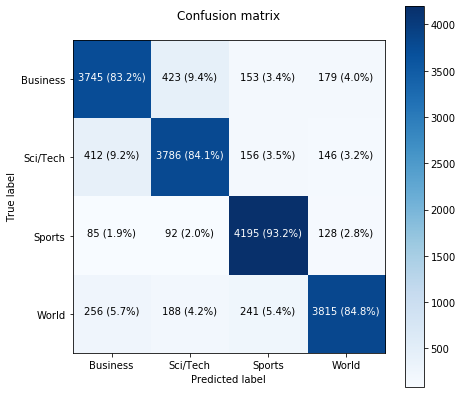

              precision    recall  f1-score   support

           0       0.83      0.83      0.83      4500
           1       0.84      0.84      0.84      4500
           2       0.88      0.93      0.91      4500
           3       0.89      0.85      0.87      4500

    accuracy                           0.86     18000
   macro avg       0.86      0.86      0.86     18000
weighted avg       0.86      0.86      0.86     18000



In [0]:
# Confusion matrix
plt.rcParams["figure.figsize"] = (7,7)
y_pred = np.argmax(y_pred, axis=1)
plot_confusion_matrix(y_test, y_pred, classes=classes)
print (classification_report(y_test, y_pred))

# Inference

In [0]:
import collections

### Components

In [0]:
def get_probability_distributions(probabilities, classes):
    """Produce probability distributions with labels."""
    probability_distributions = []
    for i, y_prob in enumerate(probabilities):
        probability_distribution = {}
        for j, prob in enumerate(y_prob):
            probability_distribution[classes[j]] = np.float64(prob)
        probability_distribution = collections.OrderedDict(
            sorted(probability_distribution.items(), key=lambda kv: kv[1], reverse=True))
        probability_distributions.append(probability_distribution)
    return probability_distributions

### Operations

In [0]:
# Inputs
texts = ["This weekend the greatest tennis players will fight for the championship."]
num_samples = len(texts)
X_infer = np.array(X_tokenizer.texts_to_sequences(texts))
print (f"{texts[0]} \n\t→ {untokenize(X_infer[0], X_tokenizer)} \n\t→ {X_infer[0]}")
print (f"len(X_infer[0]): {len(X_infer[0])} characters")
y_filler = np.array([0]*num_samples)

This weekend the greatest tennis players will fight for the championship. 
	→ this weekend the greatest tennis players will fight for the championship 
	→ [ 271 2033   10 5507  894  348   64  237    5   10 1615]
len(X_infer[0]): 11 characters


In [0]:
# Inference data generator
inference_generator = DataGenerator(X=X_infer,
                                    y=y_filler,
                                    batch_size=BATCH_SIZE,
                                    shuffle=False)

In [0]:
# Predict
probabilities = model.predict_generator(generator=inference_generator,
                                        verbose=1)

1/1 [==============================] - 0s 80ms/step


In [0]:
# Results
probability_distributions = get_probability_distributions(probabilities=probabilities,
                                                          classes=y_tokenizer.classes_)
results = []
for index in range(num_samples):
    results.append({
        'raw_input': texts[index],
        'preprocessed_input': untokenize(indices=X_infer[index], tokenizer=X_tokenizer),
        'tokenized_input': str(X_infer[index]),
        'probabilities': probability_distributions[index]
                   })
print (json.dumps(results, indent=4))

[
    {
        "raw_input": "This weekend the greatest tennis players will fight for the championship.",
        "preprocessed_input": "this weekend the greatest tennis players will fight for the championship",
        "tokenized_input": "[ 271 2033   10 5507  894  348   64  237    5   10 1615]",
        "probabilities": {
            "Sports": 0.9960770010948181,
            "World": 0.0039189341478049755,
            "Sci/Tech": 2.893947112170281e-06,
            "Business": 1.1980721410509432e-06
        }
    }
]


<img height="45" src="http://bestanimations.com/HomeOffice/Lights/Bulbs/animated-light-bulb-gif-29.gif" align="left" vspace="5px" hspace="10px">

We will learn how to get a little bit of interpretabiltiy with RNNs in the next lesson on attentional interfaces.

---
<div align="center">

Subscribe to our <a href="https://practicalai.me/#newsletter">newsletter</a> and follow us on social media to get the latest updates!

<a class="ai-header-badge" target="_blank" href="https://github.com/practicalAI/practicalAI">
              <img src="https://img.shields.io/github/stars/practicalAI/practicalAI.svg?style=social&label=Star"></a>&nbsp;
            <a class="ai-header-badge" target="_blank" href="https://www.linkedin.com/company/practicalai-me">
              <img src="https://img.shields.io/badge/style--5eba00.svg?label=LinkedIn&logo=linkedin&style=social"></a>&nbsp;
            <a class="ai-header-badge" target="_blank" href="https://twitter.com/practicalAIme">
              <img src="https://img.shields.io/twitter/follow/practicalAIme.svg?label=Follow&style=social">
            </a>
              </div>

</div>